In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_wine
from sklearn.datasets import load_iris
from sklearn.metrics import matthews_corrcoef
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import chi2
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_wine, load_iris
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, ClassifierMixin

In [5]:
class SAGAFS_GA(BaseEstimator, ClassifierMixin):

    def __init__(self, estimator, cv, scoring='accuracy', population_size=20, generations=10, mutation_rate=0.1, crossover_rate=0.5):
        if not hasattr(estimator, 'fit'):
            raise ValueError("Estimator must have a 'fit' method.")
        if not hasattr(cv, 'split'):
            raise ValueError("cv must be a cross-validation splitter (e.g., StratifiedKFold).")
        if scoring not in ['accuracy', 'matthews_corrcoef', 'f1_score']:
            raise ValueError(f"Scoring method '{scoring}' is not valid. Choose 'accuracy', 'matthews_corrcoef', or 'f1_score'.")

        self.estimator = estimator
        self.cv = cv
        self.scoring = scoring
        self.population_size = population_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.fitness_score = None
        self.best_scores_per_gen = []  # Store best fitness score for each generation

    def fit(self, X, y):
        n_features = X.shape[1]

        # Initialize population: binary vectors where 1 means feature selected and 0 not selected
        population = [np.random.randint(2, size=n_features) for _ in range(self.population_size)]

        for generation in range(self.generations):
            # Calculate fitness for each individual in the population
            fitness_scores = [self.fitness_function(X, y, individual) for individual in population]

            # Sort population based on fitness scores (highest fitness first)
            sorted_population = [x for _, x in sorted(zip(fitness_scores, population), key=lambda item: item[0], reverse=True)]

            # Store the best fitness score of this generation
            self.best_scores_per_gen.append(max(fitness_scores))

            # Elitism: Keep the top individuals
            population = sorted_population[:self.population_size // 2]

            # Create next generation through crossover and mutation
            while len(population) < self.population_size:
                parents = random.sample(population, 2)

                # Use Crossover and Mutation from the child classes
                crossover_obj = self.Crossover(self.crossover_rate)
                mutation_obj = self.Mutation(self.mutation_rate)

                child1, child2 = crossover_obj.apply(parents[0], parents[1])

                # Apply mutation
                if random.random() < self.mutation_rate:
                    child1 = mutation_obj.apply(child1)
                if random.random() < self.mutation_rate:
                    child2 = mutation_obj.apply(child2)

                population.append(child1)
                population.append(child2)

        # Select the best individual after all generations
        best_individual = max(population, key=lambda individual: self.fitness_function(X, y, individual))
        best_fitness_score = self.fitness_function(X, y, best_individual)
        self.fitness_score = best_fitness_score

        return self.fitness_score

    def fitness_function(self, X, y, feature_subset):
        selected_features = np.where(feature_subset == 1)[0]

        if selected_features.size == 0:
            return 0  # No features selected, bad fitness

        try:
            scores = cross_val_score(self.estimator, X[:, selected_features], y, cv=self.cv, scoring=self.scoring)
        except Exception as e:
            raise RuntimeError(f"Error during cross-validation: {e}")

        return np.mean(scores)

    def plot_heatmap(self, feature_scores, feature_names):
        if len(feature_scores) != len(feature_names):
            raise ValueError("Feature scores and feature names must have the same length.")

        feature_scores_reshaped = np.array(feature_scores).reshape(1, -1)
        plt.figure(figsize=(10, 1))
        sns.heatmap(feature_scores_reshaped, annot=True, cmap="coolwarm", xticklabels=feature_names, yticklabels=["Score"])
        plt.title("Feature Importance Heatmap")
        plt.show()

    def plot_fitness_over_generations(self):
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, self.generations + 1), self.best_scores_per_gen, marker='o', color='b')
        plt.title("Fitness Score Evolution Over Generations")
        plt.xlabel("Generation")
        plt.ylabel("Best Fitness Score")
        plt.grid(True)
        plt.show()

    def create_feature_names_dict(self, feature_names):
        """
        Create a dictionary of feature names.
        - feature_names: A list of feature names.
        Returns a dictionary where the key is the feature index (1-based)
        and the value is the feature name.
        """
        self.feature_names_dict = {i + 1: str(i + 1) for i in range(feature_names)}
        return self.feature_names_dict

    # Child class for crossover
    class Crossover:
        def __init__(self, crossover_rate):
            self.crossover_rate = crossover_rate

        def apply(self, parent1, parent2):
            """
            Crossover implementation based on the provided diagram.
            """
            n_features = len(parent1)
            o1 = []  # Offspring 1
            o2 = []  # Offspring 2

            # Step (a): Add common feature indices (features that both parents share)
            common_features = np.where((parent1 == parent2) & (parent1 == 1))[0]
            o1.extend(common_features)
            o2.extend(common_features)

            # Step (b): Identify non-shared features
            nC1 = np.where((parent1 == 1) & (parent2 == 0))[0]
            nC2 = np.where((parent2 == 1) & (parent1 == 0))[0]

            # Step (c): Randomly decide which non-shared features to add to which offspring
            for feature in nC1:
                if random.random() <= 0.66:  # As per the diagram, threshold is 0.66
                    o1.append(feature)
                else:
                    o2.append(feature)

            for feature in nC2:
                if random.random() <= 0.33:  # As per the diagram, threshold is 0.33
                    o2.append(feature)
                else:
                    o1.append(feature)

            # Create binary vectors from the selected feature indices
            child1 = np.zeros(n_features)
            child2 = np.zeros(n_features)
            child1[o1] = 1
            child2[o2] = 1
            print("Child1: ", child1, "Using parent1 and ", parent1, "Using parent2 ", parent2)
            print("Child2: ", child2)

            return child1, child2

    # Child class for mutation
    class Mutation:
        def __init__(self, mutation_rate):
            self.mutation_rate = mutation_rate

        def apply(self, individual):
            """
            Mutation: randomly flip a feature bit in the individual.
            """
            mutation_point = random.randint(0, len(individual) - 1)
            individual[mutation_point] = 1 - individual[mutation_point]  # Flip the bit
            return individual


# Example using Logistic Regression on Iris dataset

Child1:  [1. 1. 1. 0.] Using parent1 and  [0 1 1 1] Using parent2  [1 0 1 0]
Child2:  [0. 0. 1. 1.]
Child1:  [0. 0. 1. 1.] Using parent1 and  [0 1 1 1] Using parent2  [0 0 1 1]
Child2:  [0. 1. 1. 1.]
Child1:  [0. 0. 1. 1.] Using parent1 and  [0 0 0 1] Using parent2  [0. 0. 1. 1.]
Child2:  [0. 0. 0. 1.]
Child1:  [0. 0. 0. 1.] Using parent1 and  [0. 1. 1. 1.] Using parent2  [0 0 0 1]
Child2:  [0. 1. 1. 1.]
Child1:  [0. 0. 1. 1.] Using parent1 and  [0. 0. 0. 1.] Using parent2  [0 0 1 1]
Child2:  [0. 0. 0. 1.]
Child1:  [1. 1. 1. 1.] Using parent1 and  [1 1 1 1] Using parent2  [0 0 1 1]
Child2:  [0. 0. 1. 1.]
Child1:  [0. 1. 1. 1.] Using parent1 and  [0 1 1 1] Using parent2  [0. 1. 1. 1.]
Child2:  [0. 1. 1. 1.]
Child1:  [0. 1. 1. 1.] Using parent1 and  [1. 1. 1. 1.] Using parent2  [0. 1. 1. 1.]
Child2:  [1. 1. 1. 1.]
Child1:  [0. 1. 1. 1.] Using parent1 and  [0. 1. 1. 1.] Using parent2  [0 1 1 1]
Child2:  [0. 1. 1. 1.]
Child1:  [1. 1. 1. 1.] Using parent1 and  [1. 1. 1. 1.] Using parent2  [

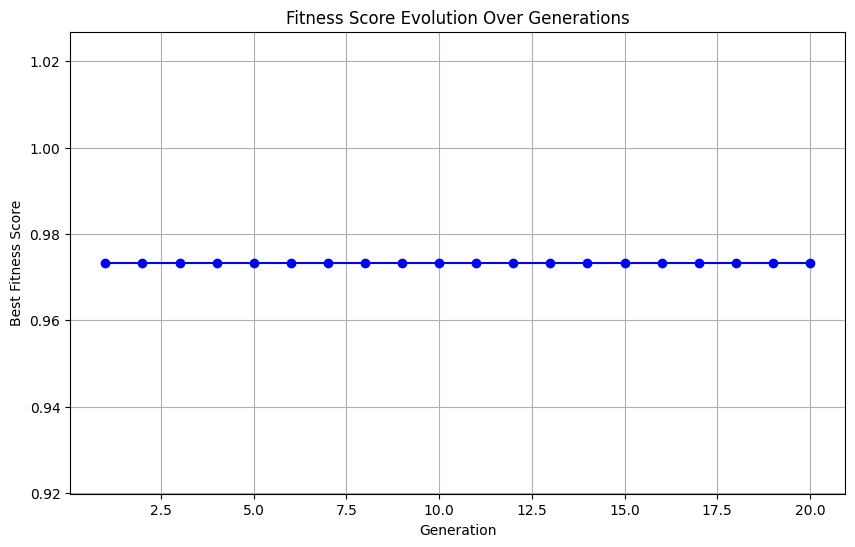

Best Fitness Score :  0.9733333333333334


In [6]:
# Load the iris dataset
dataset = load_iris()
X = dataset.data
y = dataset.target

# Define the estimator (RandomForest) and the cross-validation strategy
estimator = LogisticRegression(max_iter=1000)
cv = StratifiedKFold(n_splits=5)

# Instantiate the refactored SAGAFS_GA class
ga_fs_class_based = SAGAFS_GA(estimator=estimator, cv=cv, scoring='accuracy', population_size=10, generations=20)

# Fit the model to select the best features
best_fitness_class_based = ga_fs_class_based.fit(X, y)

# Plot fitness evolution over generations
ga_fs_class_based.plot_fitness_over_generations()

# Print the best fitness score obtained
print("Best Fitness Score : ", best_fitness_class_based)

# Example using Support Vector Machine(SVM) on Iris dataset

Child1:  [0. 1. 0. 1.] Using parent1 and  [1 1 0 1] Using parent2  [0 1 1 1]
Child2:  [1. 1. 1. 1.]
Child1:  [1. 1. 1. 1.] Using parent1 and  [1. 1. 1. 1.] Using parent2  [0 1 1 1]
Child2:  [0. 1. 1. 1.]
Child1:  [1. 1. 0. 1.] Using parent1 and  [0. 1. 0. 1.] Using parent2  [1 1 0 1]
Child2:  [0. 1. 0. 1.]
Child1:  [0. 1. 1. 1.] Using parent1 and  [0. 1. 1. 1.] Using parent2  [1. 1. 1. 1.]
Child2:  [1. 1. 1. 1.]
Child1:  [1. 1. 1. 1.] Using parent1 and  [0 1 1 1] Using parent2  [1. 0. 1. 1.]
Child2:  [0. 0. 1. 1.]
Child1:  [0. 1. 1. 1.] Using parent1 and  [1. 1. 1. 1.] Using parent2  [0 1 1 1]
Child2:  [1. 1. 1. 1.]
Child1:  [1. 0. 1. 1.] Using parent1 and  [1. 0. 1. 1.] Using parent2  [1. 1. 1. 1.]
Child2:  [1. 1. 1. 1.]
Child1:  [1. 1. 1. 1.] Using parent1 and  [1. 1. 1. 1.] Using parent2  [1. 1. 1. 1.]
Child2:  [1. 1. 1. 1.]
Child1:  [1. 1. 1. 1.] Using parent1 and  [1. 1. 1. 1.] Using parent2  [1. 1. 1. 1.]
Child2:  [1. 1. 1. 1.]
Child1:  [1. 0. 1. 1.] Using parent1 and  [1. 0. 1. 

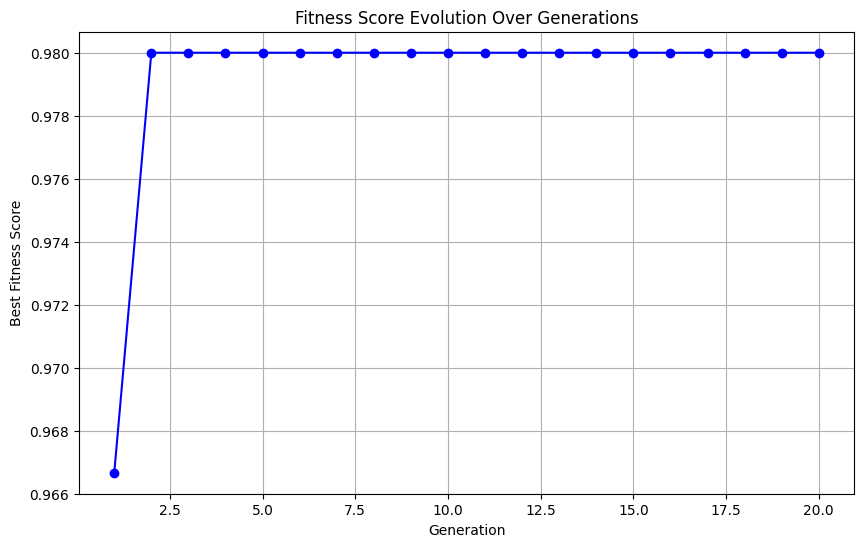

Best Fitness Score :  0.9800000000000001


In [7]:
# Load the iris dataset
dataset = load_iris()
X = dataset.data
y = dataset.target

# Define the estimator (SVM) and the cross-validation strategy
estimator = SVC(kernel='linear', random_state=42)  # Using linear kernel for SVM
cv = StratifiedKFold(n_splits=5)

# Instantiate the refactored SAGAFS_GA class with crossover and mutation as child classes
ga_fs_class_based = SAGAFS_GA(estimator=estimator, cv=cv, scoring='accuracy', population_size=10, generations=20)

# Fit the model to select the best features
best_fitness_class_based = ga_fs_class_based.fit(X, y)

# Plot fitness evolution over generations
ga_fs_class_based.plot_fitness_over_generations()

# Print the best fitness score obtained
print("Best Fitness Score : ", best_fitness_class_based)


# Example using Random Forest Classifier on Iris dataset

Child1:  [1. 1. 1. 1.] Using parent1 and  [1 1 1 1] Using parent2  [1 1 1 1]
Child2:  [1. 1. 1. 1.]
Child1:  [0. 1. 1. 1.] Using parent1 and  [0 1 1 1] Using parent2  [1 1 1 1]
Child2:  [1. 1. 1. 1.]
Child1:  [1. 1. 1. 1.] Using parent1 and  [1. 1. 1. 1.] Using parent2  [1 1 0 1]
Child2:  [1. 1. 0. 1.]
Child1:  [1. 1. 1. 1.] Using parent1 and  [1 1 1 1] Using parent2  [1 1 1 1]
Child2:  [1. 1. 1. 1.]
Child1:  [1. 1. 1. 1.] Using parent1 and  [1 1 1 1] Using parent2  [1. 1. 1. 1.]
Child2:  [1. 1. 1. 1.]
Child1:  [1. 1. 1. 1.] Using parent1 and  [1. 1. 1. 1.] Using parent2  [1. 1. 1. 1.]
Child2:  [1. 1. 1. 1.]
Child1:  [1. 1. 1. 1.] Using parent1 and  [1. 1. 1. 1.] Using parent2  [1 1 1 1]
Child2:  [1. 1. 1. 1.]
Child1:  [1. 1. 1. 1.] Using parent1 and  [1 1 1 1] Using parent2  [1 1 1 1]
Child2:  [1. 1. 1. 1.]
Child1:  [1. 1. 1. 1.] Using parent1 and  [1. 1. 1. 1.] Using parent2  [1. 1. 1. 1.]
Child2:  [1. 1. 1. 1.]
Child1:  [1. 1. 1. 1.] Using parent1 and  [1 1 1 1] Using parent2  [1 1 

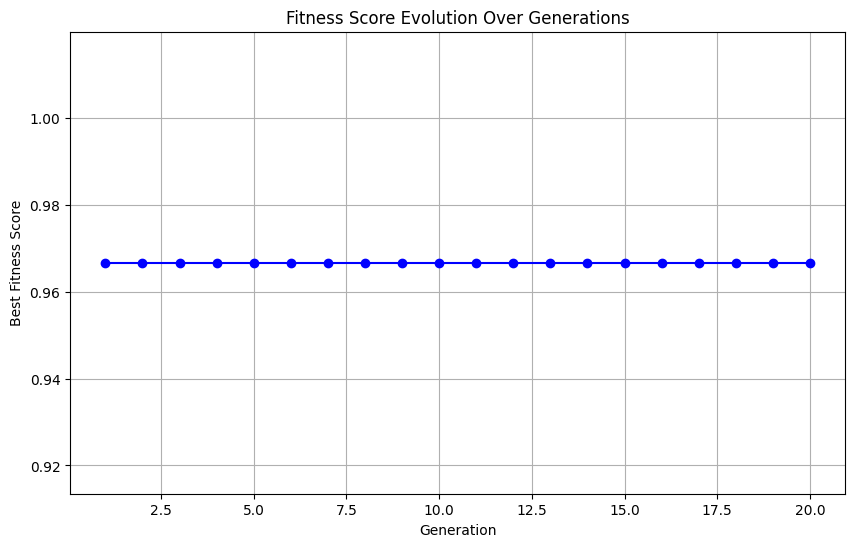

Best Fitness Score :  0.9666666666666668


In [8]:
# Load the iris dataset
dataset = load_iris()
X = dataset.data
y = dataset.target

estimator = RandomForestClassifier(n_estimators=50, random_state=42)
cv = StratifiedKFold(n_splits=5)

# Instantiate the refactored SAGAFS_GA class
ga_fs_class_based = SAGAFS_GA(estimator=estimator, cv=cv, scoring='accuracy', population_size=10, generations=20)

# Fit the model to select the best features
best_fitness_class_based = ga_fs_class_based.fit(X, y)

# Plot fitness evolution over generations
ga_fs_class_based.plot_fitness_over_generations()

# Print the best fitness score obtained
print("Best Fitness Score : ", best_fitness_class_based)